In [1]:
import matplotlib.pyplot as plt

import numpy as np
import torch

from models import MLP
from datas import get_dataset_2d_gaussian

# Dataset

In [13]:
batch_size = 32
trainset, trainloader, testset, testloader, classes = get_dataset_2d_gaussian(batch_size)
print(len(trainloader))

141


# Model

In [14]:
in_dim, out_dim, hidden_dim, num_hidden_layers = 2, 4, 8, 4
model = MLP(in_dim, out_dim, hidden_dim, num_hidden_layers)

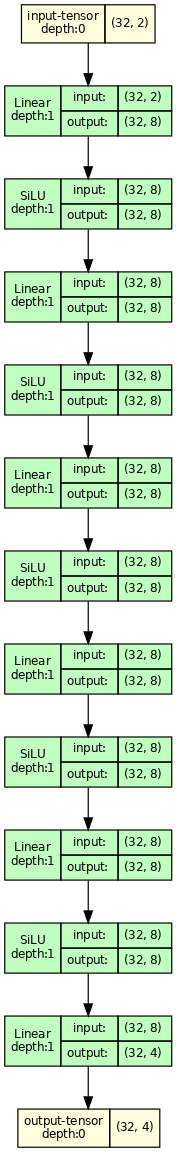

In [15]:
from torchview import draw_graph
import graphviz
graphviz.set_jupyter_format('png')

# device='meta' -> no memory is consumed for visualization
model_graph = draw_graph(model, input_size=(batch_size, in_dim), device='meta')
model_graph.visual_graph

# Train

In [ ]:
def get_model_dtype(model):
    return next(model.parameters()).dtype

In [ ]:
model = model.to('cuda')
dtype = get_model_dtype(model)
losser = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(model.parameters())
print(dtype)
num_epoch = 20

In [ ]:
epoch_eval_losses = []
epoch_train_avg_losses = []
epoch_eval_accs = []
batch_losses = []
for epoch in range(num_epoch):
    epoch_train_losses = []
    for batch in trainloader:
        samples, labels = batch
        samples = samples.to('cuda', dtype=dtype)
        labels = labels.to('cuda', dtype=torch.long)
        pred = model(samples)
        loss = losser(pred, labels)
        optim.zero_grad()
        loss.backward()
        optim.step()
        epoch_train_losses.append(loss.item())

    num_samples, correct, eval_loss = 0, 0, 0
    for batch in testloader:
        with torch.no_grad():
            samples, labels = batch
            samples = samples.to('cuda', dtype=dtype)
            labels = labels.to('cuda', dtype=torch.long)
            model_output = model(samples)
            pred = torch.argmax(model_output, dim=-1)
            num_correct = torch.sum(pred == labels)
            num_samples += pred.shape[0]
            correct += num_correct
            eval_loss += torch.nn.functional.cross_entropy(model_output, labels, reduction='none').sum()
    
    batch_losses.extend(epoch_train_losses)
    epoch_train_avg_losses.append(np.mean(epoch_train_losses))
    epch_eval_loss = eval_loss/num_samples
    epoch_eval_acc = correct / num_samples
    epoch_eval_losses.append(epch_eval_loss.item())
    epoch_eval_accs.append(epoch_eval_acc.item())
    print(f'epoch {epoch}, train avg loss {np.mean(epoch_train_losses)}, eval loss {epch_eval_loss: .02f}, eval acc {epoch_eval_acc: .02f}')

In [ ]:
plt.plot(batch_losses, label='mini batch losses')
plt.legend()
plt.show()

plt.plot(epoch_train_avg_losses, label='epoch train avg loss')
plt.plot(epoch_eval_losses, label='epoch eval losses')
plt.legend()
plt.show()

plt.plot(epoch_eval_accs, label='epoch test acc')
plt.legend()
plt.show()


In [ ]:
num_samples, correct = 0, 0
for batch in trainloader:
    with torch.no_grad():
        samples, labels = batch
        samples = samples.to('cuda', dtype=dtype)
        labels = labels.to('cuda', dtype=torch.long)
        model_output = model(samples)
        pred = torch.argmax(model_output, dim=-1)
        num_correct = torch.sum(pred == labels)
        num_samples += pred.shape[0]
        correct += num_correct

print(correct / num_samples)


# Plot the data

In [ ]:
data = trainset.samples
labels = trainset.labels
class_labels = np.unique(labels)

In [ ]:


for class_label in class_labels:
    class_samples = data[labels == class_label]
    plt.scatter(class_samples[:, 0], class_samples[:, 1], label=f'class {class_label}', marker='.')

plt.legend()